# MIL Model

## Imports

In [1]:
import numpy as np
import tensorflow as tensorflow
from io import StringIO
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalMaxPooling1D, Masking, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay, auc, precision_recall_curve

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

import matplotlib.pyplot as plt

## Import Data

In [2]:
# load numpy arrays
loaded = np.load('../data/MIL_padded_data.npz')
X_array = loaded['x']
y_vector = loaded['y']


In [4]:
X_array

array([[[2.99e-03, 2.06e+00, 1.25e+02, ..., 9.30e-03, 1.09e+01,
         8.41e+01],
        [6.31e-03, 2.53e+00, 1.25e+02, ..., 1.03e-02, 6.30e+00,
         8.09e+01],
        [4.65e-03, 3.92e+00, 1.09e+02, ..., 4.98e-03, 2.13e+00,
         7.96e+01],
        ...,
        [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00,
         0.00e+00],
        [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00,
         0.00e+00],
        [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00,
         0.00e+00]],

       [[1.26e-02, 1.95e+00, 1.11e+02, ..., 9.96e-03, 2.94e+00,
         1.01e+02],
        [4.32e-03, 2.35e+00, 1.11e+02, ..., 3.32e-03, 1.39e+00,
         9.45e+01],
        [2.66e-03, 3.81e+00, 1.08e+02, ..., 8.27e-03, 2.12e+00,
         9.33e+01],
        ...,
        [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00,
         0.00e+00],
        [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00,
         0.00e+00],
        [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00

In [5]:
y_vector

array([0, 0, 0, ..., 1, 0, 0])

In [3]:
# Grouping Information
with open('../data/data.info.labelled') as r:
    labels = r.read()

labels_df = pd.read_csv(StringIO(labels))

groups = labels_df['gene_id'].values

## Data

In [5]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=21)

for train_idx, test_idx in gss.split(X_array, y_vector, groups):
    X_train, X_test = X_array[train_idx], X_array[test_idx]
    y_train, y_test = y_vector[train_idx], y_vector[test_idx]


In [6]:
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (96350, 991, 9)
Test data shape: (25488, 991, 9)
Training labels shape: (96350,)
Test labels shape: (25488,)


In [7]:
print(f"Training class distribution: {Counter(y_train)}")
print(f"Test class distribution: {Counter(y_test)}")



Training class distribution: Counter({0: 91995, 1: 4355})
Test class distribution: Counter({0: 24368, 1: 1120})


Oversampling

In [ ]:
num_bags, max_num_instances, num_features = X_train.shape
X_train_reshaped = X_train.reshape((num_bags, max_num_instances * num_features))

ros = RandomOverSampler(random_state=21)
X_train_resampled_2D, y_train = ros.fit_resample(X_train_reshaped, y_train)

num_resampled_bags = X_train_resampled_2D.shape[0]
X_train = X_train_resampled_2D.reshape((num_resampled_bags, max_num_instances, num_features))


In [ ]:
print("X_train_resampled_final shape:", X_train_resampled_final.shape)
print("y_train_resampled_final shape:", y_train_resampled.shape)

In [9]:
# # Assuming X_train is a 3D array with shape (num_bags, max_num_instances, num_features)
# # and y_train is a 1D array with shape (num_bags,)

# # Step 1: Create a mask for non-padded values (True if non-padded, False if padded)
# non_padded_mask = np.any(X_train != 0, axis=-1)  # Shape: (num_bags, max_num_instances)

# # Step 2: Use this mask to calculate the mean, excluding padded zeros
# # Initialize an array to hold the flattened representations
# X_train_flattened = np.zeros((X_train.shape[0], X_train.shape[2]))  # Shape: (num_bags, num_features)

# # Iterate over each bag and calculate the mean of non-padded values for each feature
# for i in range(X_train.shape[0]):
#     non_padded_instances = X_train[i][non_padded_mask[i]]
#     if non_padded_instances.size == 0:
#         X_train_flattened[i] = 0  # If the bag is completely padded, assign zeros (or another placeholder)
#     else:
#         X_train_flattened[i] = np.mean(non_padded_instances, axis=0)

# # X_train_flattened now contains the mean of each bag, ignoring padded values

# # Step 3: Apply scaling (optional, but recommended)
# scaler = StandardScaler()
# X_train_flattened_scaled = scaler.fit_transform(X_train_flattened)

# # Step 4: Apply SMOTE on the flattened training data
# smote = SMOTE(random_state=21)
# X_train_resampled_flat, y_train_resampled = smote.fit_resample(X_train_flattened_scaled, y_train)

# # Step 5: Reverse the scaling for the resampled data
# X_train_resampled_flat = scaler.inverse_transform(X_train_resampled_flat)

# # Step 6: Reconstruct synthetic bags using the padding strategy
# # Determine the number of instances per bag (use the same number as in the original training data)
# num_instances = X_train.shape[1]

# # Reshape the synthetic samples back into 3D bags by replicating the feature vector across instances
# X_train_synthetic_bags = np.tile(X_train_resampled_flat[:, np.newaxis, :], (1, num_instances, 1))

# # Combine the original majority class bags with the synthetic minority class bags
# majority_indices = np.where(y_train == 0)[0]
# X_train_majority = X_train[majority_indices]
# y_train_majority = y_train[majority_indices]

# # Concatenate the synthetic bags with the original majority class bags
# X_train = np.concatenate([X_train_majority, X_train_synthetic_bags], axis=0)
# y_train = np.concatenate([y_train_majority, y_train_resampled], axis=0)

# # Check the shape of the resampled training data
# print("X_train_resampled_final shape:", X_train.shape)
# print("y_train_resampled_final shape:", y_train.shape)


## Model

In [11]:
model = Sequential()

input_shape = (X_train.shape[1], X_train.shape[2]) # Shape

model.add(Input(shape=input_shape))
model.add(Masking(mask_value=0.0))
model.add(Dense(64, activation='relu')) 
model.add(Dense(32, activation='relu'))

model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))


/Users/arnoldlek/Desktop/DSA4262/lib/python3.11/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall', 'auc'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True)

In [13]:
history = model.fit(X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=50, 
    batch_size=32, 
    callbacks=[early_stopping])

Epoch 1/50
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - accuracy: 0.9529 - auc: 0.5794 - loss: 0.2572 - precision: 0.0709 - recall: 0.0021 - val_accuracy: 0.9554 - val_auc: 0.5925 - val_loss: 0.1832 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.9565 - auc: 0.6433 - loss: 0.1749 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9554 - val_auc: 0.6460 - val_loss: 0.1771 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.9549 - auc: 0.6799 - loss: 0.1737 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9554 - val_auc: 0.6760 - val_loss: 0.1750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
2070/2611 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9555 - auc: 0.7055 - loss: 0.1683 - precision: 0.0000e+00 - recall: 0.0000e+00

KeyboardInterrupt: 

762/762 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
AUC Score: 0.8369


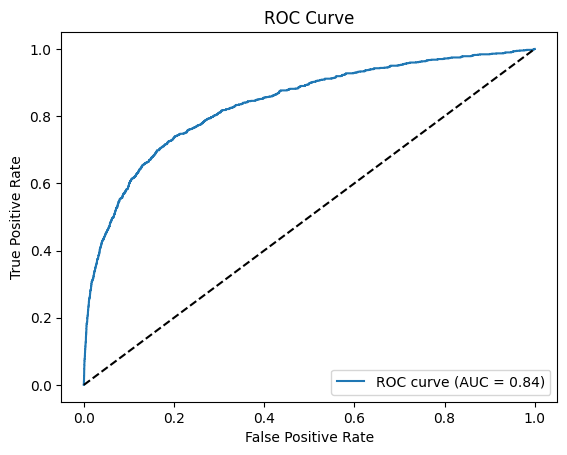

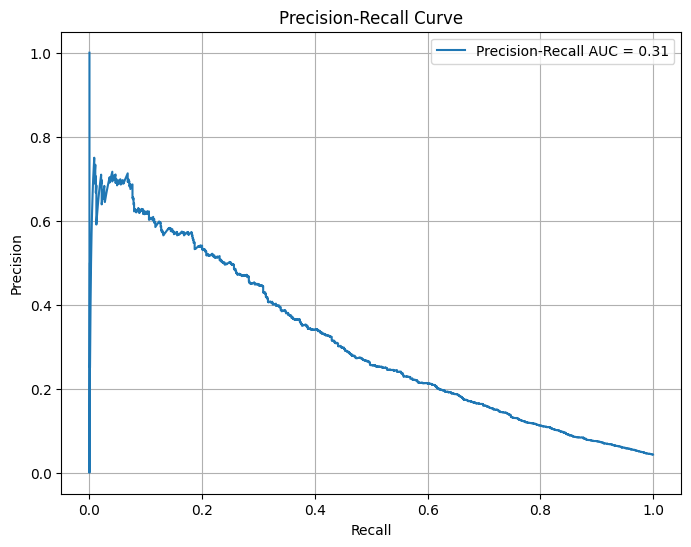

Text(0.5, 1.0, 'Confusion Matrix for QDA')

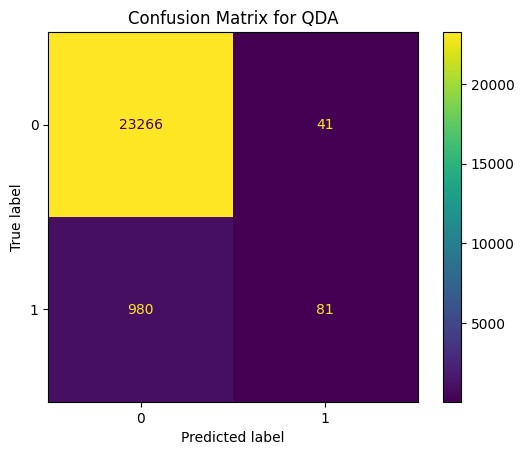

In [11]:
# Predict probabilities for the test set
y_pred_proba = model.predict(X_test)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

# Plot the ROC curve
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# PR-AUC
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Compute the AUC for the precision-recall curve
pr_auc = auc(recall, precision)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall AUC = {pr_auc:.2f}')1
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

# Confusion matrix
y_pred_class = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to class labels
cm = confusion_matrix(y_test, y_pred_class)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.title('Confusion Matrix for QDA')